<a href="https://colab.research.google.com/github/Normallysamaksh/Assignment1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

ROLL_NUMBER = 102316049
DATASET_PATH = "Creditcard_data.csv"
print(f"Configuration set. Random seed: {ROLL_NUMBER}")

Configuration set. Random seed: 102316049


In [2]:
def load_and_balance_data(file_path, seed):
    """
    Loads the credit card dataset and balances the classes using oversampling.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: '{file_path}' not found. Please upload the file to Colab.")
        return None, None

    class_0 = df[df['Class'] == 0]
    class_1 = df[df['Class'] == 1]


    class_1_over = class_1.sample(n=len(class_0), replace=True, random_state=seed)

    balanced_df = pd.concat([class_0, class_1_over])
    balanced_df = balanced_df.sample(frac=1, random_state=seed).reset_index(drop=True)

    print(f"Dataset balanced. New shape: {balanced_df.shape}")
    print(f"Class distribution:\n{balanced_df['Class'].value_counts()}")

    X = balanced_df.drop('Class', axis=1)
    y = balanced_df['Class']

    return X, y

X, y = load_and_balance_data(DATASET_PATH, ROLL_NUMBER)

Dataset balanced. New shape: (1526, 31)
Class distribution:
Class
0    763
1    763
Name: count, dtype: int64


In [3]:

def get_simple_random_sample(X, y, seed):
    """Simple Random Sampling using train_test_split."""

    return train_test_split(X, y, test_size=0.25, random_state=seed)

def get_stratified_sample(X, y, seed):
    """Stratified Sampling ensuring class proportions are kept."""
    return train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

def get_systematic_sample(X, y, seed):
    """Systematic Sampling simulated via K-Fold."""
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    train_idx, test_idx = next(kf.split(X))
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

def get_cluster_sample(X, y, seed):
    """Cluster Sampling simulated via Stratified K-Fold."""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    train_idx, test_idx = next(skf.split(X, y))
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

def get_bootstrap_sample(X, y, seed):
    """Bootstrap Sampling (Sampling with replacement)."""
    combined = pd.concat([X, y], axis=1)
    boot_sample = combined.sample(frac=1, replace=True, random_state=seed)

    X_boot = boot_sample.drop('Class', axis=1)
    y_boot = boot_sample['Class']

    return train_test_split(X_boot, y_boot, test_size=0.25, random_state=seed)

print("Sampling functions defined.")

Sampling functions defined.


In [4]:
models_dict = {
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=ROLL_NUMBER),
    "Random Forest": RandomForestClassifier(random_state=ROLL_NUMBER),
    "SVM": SVC()
}

samplers_dict = {
    "Simple Random": get_simple_random_sample,
    "Stratified": get_stratified_sample,
    "Systematic": get_systematic_sample,
    "Cluster": get_cluster_sample,
    "Bootstrap": get_bootstrap_sample
}

print("Models and Samplers initialized.")

Models and Samplers initialized.


In [5]:
results_df = pd.DataFrame(index=models_dict.keys(), columns=samplers_dict.keys())

scaler = StandardScaler()

if X is not None:
    print("Starting model evaluation...")
    for sampler_name, sampler_func in samplers_dict.items():
        X_train, X_test, y_train, y_test = sampler_func(X, y, ROLL_NUMBER)

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model in models_dict.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            acc = accuracy_score(y_test, y_pred)
            results_df.loc[model_name, sampler_name] = acc * 100

    print("\nEvaluation Complete. Results:")
    print(results_df)
else:
    print("Data not loaded. Check Block 2.")

Starting model evaluation...

Evaluation Complete. Results:
                    Simple Random Stratified Systematic    Cluster  Bootstrap
Logistic Regression     91.884817  90.575916  92.156863  93.464052  93.455497
KNN                     98.167539  97.382199  98.039216  97.712418  98.429319
Decision Tree            98.95288   99.47644  99.346405  99.019608   99.73822
Random Forest               100.0      100.0      100.0      100.0      100.0
SVM                     98.167539  98.691099  98.366013  97.385621  98.429319


<Figure size 1400x800 with 0 Axes>

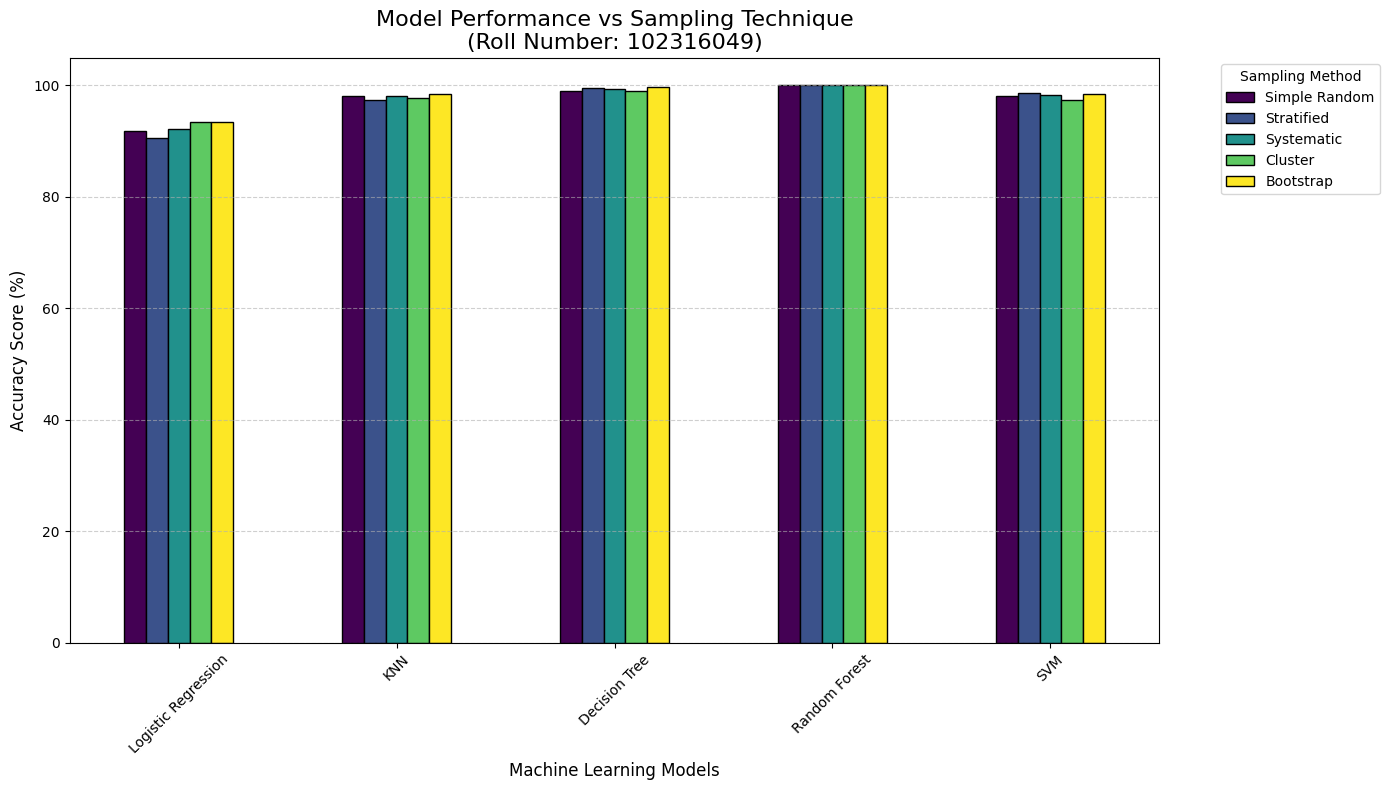

In [6]:
if not results_df.isnull().values.any():
    plt.figure(figsize=(14, 8))
    results_df.astype(float).plot(kind='bar', figsize=(14, 8), colormap='viridis', edgecolor='black')

    plt.title(f"Model Performance vs Sampling Technique\n(Roll Number: {ROLL_NUMBER})", fontsize=16)
    plt.ylabel("Accuracy Score (%)", fontsize=12)
    plt.xlabel("Machine Learning Models", fontsize=12)
    plt.legend(title="Sampling Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot.")